Importing useful libraries and importing the drive for the dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import torch
import torch.nn as nn
import sklearn
import pandas as pd
import io
import math
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive

Mounted at /content/drive
/content/drive/My Drive


Importing the data

In [3]:
pddata = pd.read_csv('GSM1586785_ScrH-12A_Exd_14mer_cg.csv.zip', compression='zip', error_bad_lines=False, skiprows=1)

In [4]:
pddata = pddata.to_numpy()
RelKa = pddata[:, -1]
training_data = pddata[:, 2:-1]

Some helpers function for the analysis below

In [5]:
def drop_outliers(x, y, outliers):
  x = np.delete(x, outliers, axis=0)
  y = np.delete(y, outliers, axis=0)
  return x, y

In [6]:
from sklearn import preprocessing

def standardize(x):
  scaler = preprocessing.StandardScaler().fit(training_data)
  x = scaler.transform(x)
  return x

In [7]:
def split_RelKa(y, p):
  return np.array([1 if value > p else 0 for value in y])

In [8]:
from sklearn.ensemble import RandomForestClassifier

def predict_with_Random_Forests(x_train, x_test, y_train, y_test):
  clf = RandomForestClassifier(n_estimators=100, criterion='entropy')
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)  
  return y_pred

In [9]:
from sklearn import metrics

def return_accuracy(y_test, y_pred, verbose=1):
  C = metrics.confusion_matrix(y_test, y_pred)
  accuracy = np.trace(C) / len(y_test)
  if verbose == 1:
    print("The number of true negatives is:", C[0, 0])
    print("The number of false negatives is:", C[1,0])
    print("The number of false positives is:", C[0,1])  
    print("The number of true positives is:", C[1,1])
    print("The accuracy is:", accuracy)
  return accuracy

ISOLATION FORESTS ANOMALY DETECTION

In [16]:
from sklearn.ensemble import IsolationForest

def Anomaly_Detection_Isolation_Forests(x):
  random_state = np.random.RandomState(42)
  contamination = 'auto'
  model = IsolationForest(n_estimators=120, max_samples='auto', contamination=contamination, random_state=random_state)
  model.fit(x)
  scores = model.decision_function(x)
  anomaly_score = model.predict(x)
  outliers_indices = np.where(anomaly_score == -1)[0] 
  return contamination, scores, anomaly_score, outliers_indices

def check_Isolation_Forests(contamination, outliers_indices):
  """
  Simply a check on the proper working of the IF algorithm
  """
  tol = 1.0e-02
  if contamination != 'auto':
    outliers_percentage = 1 / len(RelKa) * len(outliers_indices)
    assert np.abs(contamination-outliers_percentage) < tol

def check_boundary_decision(scores, p, verbose=1):
  """
  This function simply controls how many scores returned by the IF algorithm 
  are likely to be misclassified
  """
  indecision_percentage = 1 / len(RelKa) * np.count_nonzero(np.abs(scores) <= p)
  if verbose == 1:
    plt.hist(scores)
    plt.show()
    print("The indecision percentage around", p,  "is", indecision_percentage)

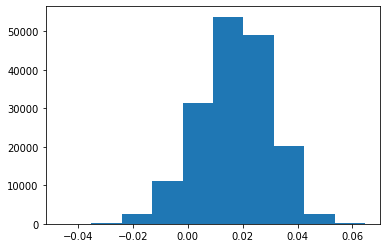

The indecision percentage around 0.02 is 0.5672001406964474


In [17]:
contamination, scores, anomaly_score, outliers_indices = Anomaly_Detection_Isolation_Forests(training_data)
check_Isolation_Forests(contamination, outliers_indices)
check_boundary_decision(scores, 0.02, verbose=1)

In [18]:
training_data, RelKa = drop_outliers(training_data, RelKa, outliers_indices)
training_data = standardize(training_data)
RelKa_tilda = split_RelKa(RelKa, 0.5)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(training_data, RelKa_tilda, train_size=0.7, random_state=42)

In [20]:
y_pred = predict_with_Random_Forests(X_train, X_test, y_train, y_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)

The number of true negatives is: 45200
The number of false negatives is: 247
The number of false positives is: 54
The number of true positives is: 405
The accuracy is: 0.9934431229033241


We see that we have a problem with a large number of false negatives, namely with incorrectly predictions of the negative class

A further insight on the errors has to be done, but probably increasing the threshold 0.5 helps already a lot

LOCAL OUTLIER FACTOR ANOMALY DETECTION
The quickness here is really depending on the number of neighbours, for example
n_neigbors = 20 is already too much and Isolation Forests may be already considered preferable as they are quite efficient without incurring in large running times.


In [ ]:
from sklearn.neighbors import LocalOutlierFactor 

def LOF_Anomaly_Detection(X):
  clf = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, contamination='auto', novelty=False)
  anomaly_score = clf.fit_predict(X)
  scores = clf.negative_outlier_factor(X)
  outliers_indices = np.where(anomaly_score == -1)[0]
  return scores, outliers_indices

In [ ]:
training_data, RelKa = drop_outliers(training_data, RelKa, outliers_indices)
training_data = standardize(training_data)
RelKa_tilda = split_RelKa(RelKa, 0.5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(training_data, RelKa_tilda, test_size=0.7, random_state=42)

In [ ]:
y_pred = predict_with_Random_Forests(X_train, X_test, y_train, y_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)

# CROSS VALIDATION (5-FOLD) TO FINETUNE THE RF PARAMETERS

In [21]:
X_train, X_test, y_train, y_test = train_test_split(training_data, RelKa_tilda, test_size=0.7, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 5)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=10)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START min_samples_leaf=1, min_samples_split=2, n_estimators=100..
[CV 1/5; 1/10] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.991 total time= 1.5min
[CV 2/5; 1/10] START min_samples_leaf=1, min_samples_split=2, n_estimators=100..
[CV 2/5; 1/10] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.992 total time= 1.6min
[CV 3/5; 1/10] START min_samples_leaf=1, min_samples_split=2, n_estimators=100..
[CV 3/5; 1/10] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.991 total time= 1.6min
[CV 4/5; 1/10] START min_samples_leaf=1, min_samples_split=2, n_estimators=100..
[CV 4/5; 1/10] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.991 total time= 1.6min
[CV 5/5; 1/10] START min_samples_leaf=1, min_samples_split=2, n_estimators=100..
[CV 5/5; 1/10] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.992 tot

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 125, 150, 175,
                                                         200]},
                   verbose=10)

In [23]:
clf = RandomForestClassifier(n_estimators=150, min_samples_leaf=1, min_samples_split=2, criterion='entropy')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)

The number of true negatives is: 105503
The number of false negatives is: 717
The number of false positives is: 119
The number of true positives is: 775
The accuracy is: 0.9921952312489497


We see that the accuracy is slightly decreasing with respect to the case in which the parameters were not tuned